Copyright (C) 2023 Ming-Fong Sie <seansie07@gmail.com> & Yu-Jing Lin <elvisyjlin@gmail.com>

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

#### Some Abbreviations
1. cm: confusion matrix
2. rp: classification report
3. fi: feature importance
4. if: important features

In [1]:
# Import all used packages

import argparse
import collections
import json
import numpy as np
import os
import pandas as pd
import pickle
import sys
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score  # Add this import statement at the beginning

from tqdm import tqdm

from learn import get_model, get_params
from utils import run_from_ipython, np2df
from viz import show_cm_list, show_rp_list

if run_from_ipython():
    import matplotlib
    # %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
    import xgboost
    sns.set_context('notebook')  # 'notebook', 'paper', 'talk', 'poster'
    # sns.set_style('dark')  # None, 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'

In [2]:
# Parse Arguments

def parse(args=None):
    parser = argparse.ArgumentParser(
        prog='Classification',
        description='Train and test a machine learning classification method on the extracted features.'
    )
    parser.add_argument('--n_folds', help='n folds cross validation', type=int, default=10)
    parser.add_argument('--model', '-m', help='model/method', type=str,
                        choices=['lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb'], default='rf')
    parser.add_argument('--feature_type', '-f',
                        help='feature type ("b" | "e" | "m" or "if4", "if5", "if10", "if13", "if20", "if64")',
                        type=str, default='bem')
    parser.add_argument('--scheme', '-s', help='data scheme', type=str,
                        choices=['address', 'entity'], default='address')
    parser.add_argument('--n_jobs', '-j', help='number of workers/threads; set -1 to use all processors', type=int, default=10)
    parser.add_argument('--no_cost_sentitive', help='disable cost sentitive learning', action='store_true')
    parser.add_argument('--output', '-o', help='output path', type=str, default='./data_p')
    parser.add_argument('--result', '-r', help='result path', type=str, default='./result')
    return parser.parse_args() if args is None else parser.parse_args(args)
args = parse([]) if run_from_ipython() else parse()
print(args)

Namespace(feature_type='bem', model='rf', n_folds=10, n_jobs=10, no_cost_sentitive=False, output='./data_p', result='./result', scheme='address')


In [3]:
# Define the experiment setting

n_folds = args.n_folds                       # 10
model = args.model                           # 'lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb'
feature_type = args.feature_type             # 'b' | 'e' | 'm' or 'if4', 'if5', 'if10', 'if13', 'if20', 'if64'
scheme = args.scheme                         # 'address', 'entity'
n_jobs = args.n_jobs                         # -1 to use all processors, or any positive integer
cost_sensitive = not args.no_cost_sentitive  # True, False
output_path = args.output
result_path = args.result

# Check the experiment setting

assert model in ['lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb']
assert not feature_type.startswith('if') and len(feature_type) > 0 or \
       feature_type.startswith('if') and feature_type[2:].isdigit()
# assert scheme in ['address', 'entity']
assert scheme in ['address']

# Show the experiment setting

print('Experiment Setting')
print('===> Model:         ', model)
print('===> Feature Types: ', feature_type)
print('===> Data Scheme:   ', scheme)
print('===> Cost Sensitive:', cost_sensitive)
print('===> N Threads:     ', n_jobs)

Experiment Setting
===> Model:          rf
===> Feature Types:  bem
===> Data Scheme:    address
===> Cost Sensitive: True
===> N Threads:      10


In [4]:
# Load transaction history summarization data

# data_file = 'data.{}.csv'.format(scheme)
data_file = 'nanzero_data.{}.csv'.format(scheme)
# data_file = 'quantum_qubo_data.{}.csv'.format(scheme)
# data_file = 'all_selected_features_quantum_qubo_data.{}.csv'.format(scheme)
data = pd.read_csv(os.path.join(output_path, data_file))
print (data)
if run_from_ipython():
    data.head(4)
else:
    print(data.head(4))

        n_tx  total_days  total_spent_btc  total_received_btc  \
0        1.0         1.0         0.002757            0.002757   
1        1.0         1.0         0.011048            0.011048   
2        2.0        91.0         0.714653            0.714653   
3        1.0         1.0         1.120000            1.120000   
4        1.0         1.0         0.010039            0.010039   
...      ...         ...              ...                 ...   
694671   1.0         1.0         0.011394            0.011394   
694672   1.0         1.0         0.010000            0.010000   
694673   1.0         1.0         0.010000            0.010000   
694674   4.0         6.0        10.173900           10.173900   
694675   2.0         1.0         0.600000            0.600000   

        total_spent_usd  total_received_usd  mean_balance_btc  \
0              1.147915            1.147915          0.002757   
1              2.918842            2.918842          0.011048   
2            188.487957 

In [5]:
# Define 3 types of features (basic statistics, extra statistics, and moments)

basic = [
    'f_tx', 'f_received', 'f_coinbase',
    'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0',
    'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4',
    'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2',
    'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2',
    'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6',
    'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent'
]
extra = [
    'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback',
    'total_spent_btc', 'total_received_btc',
    'total_spent_usd', 'total_received_usd',
    'mean_balance_btc', 'std_balance_btc',
    'mean_balance_usd', 'std_balance_usd'
]
moments = [
    'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment',
    'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment',
    'dist_coinbase_1st_moment', 'dist_coinbase_2nd_moment', 'dist_coinbase_3rd_moment', 'dist_coinbase_4th_moment',
    'dist_spend_1st_moment', 'dist_spend_2nd_moment', 'dist_spend_3rd_moment', 'dist_spend_4th_moment',
    'dist_receive_1st_moment', 'dist_receive_2nd_moment', 'dist_receive_3rd_moment', 'dist_receive_4th_moment',
    'dist_payback_1st_moment', 'dist_payback_2nd_moment', 'dist_payback_3rd_moment', 'dist_payback_4th_moment'
]

features = []
if not feature_type.startswith('if') and len(feature_type) > 0:
    if 'b' in feature_type:
        features += basic
    if 'e' in feature_type:
        features += extra
    if 'm' in feature_type:
        features += moments
elif feature_type.startswith('if') and feature_type[2:].isdigit():
    """
    Important features from LightGBM with BEM
    [ 0 25 24 29 40 37 27 23 56 36  1 28 26 57 32 38 44 45 33 18 39 60 53 35
     34 52 41 17 14 15 16 19 42  5  6 47  7 46  2 54  4 43  8 59 58 55  9 13
     61 48  3 31 10 62 20 21 63 30 49 11 51 50 22 12]
    """
    all_features = basic + extra + moments
    if_indices = [
        0, 25, 24, 29, 40, 37, 27, 23, 56, 36,
        1, 28, 26, 57, 32, 38, 44, 45, 33, 18,
        39, 60, 53, 35, 34, 52, 41, 17, 14, 15,
        16, 19, 42, 5, 6, 47, 7, 46, 2, 54,
        4, 43, 8, 59, 58, 55, 9, 13, 61, 48,
        3, 31, 10, 62, 20, 21, 63, 30, 49, 11,
        51, 50, 22, 12
    ]
    if_features = [all_features[i] for i in if_indices]
    n_if = int(feature_type[2:])
    features = if_features[:n_if]
else:
    raise Exception('Invalid feature types: {:s}'.format(feature_type))

invalid_features = [feature for feature in features if feature not in data.columns]
assert len(invalid_features) == 0, 'Invalid features: ' + ', '.join(invalid_features)

X = data.get(features).values
y = data['class'].values
print (features)
print (feature_type)
print (X)
print (y)

class2label = json.loads(open(os.path.join(output_path, 'class2label.json'), 'r').read())
label2class = json.loads(open(os.path.join(output_path, 'label2class.json'), 'r').read())
class_names = np.array([label2class[i] for i in range(6)])
print (class_names)
y_names = class_names
# y_names = class_names[y]
# y_names = np.array(class_names)[y.astype(int)]

print(len(X), len(y), len(features))

os.makedirs(result_path, exist_ok=True)

['f_tx', 'f_received', 'f_coinbase', 'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0', 'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4', 'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2', 'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2', 'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6', 'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent', 'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback', 'total_spent_btc', 'total_received_btc', 'total_spent_usd', 'total_received_usd', 'mean_balance_btc', 'std_balance_btc', 'mean_balance_usd', 'std_balance_usd', 'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment', 'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment', 'dist_coinbase_1st_moment', 'dist_coinbase_2n

{'Exchange': 0, 'Faucet': 1, 'Gambling': 2, 'Market': 3, 'Mixer': 4, 'Pool': 5}
          0    1    2    3    4    5    6    7    8    9   ...        54  \
1   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
0   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
3   0.021978  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
4   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
2   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
..       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
5   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
4   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
5   1.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
5   0.666667  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.249329   
2   2.000000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   

       

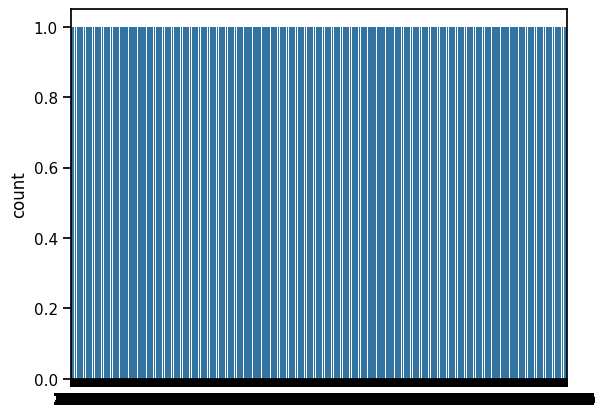

In [6]:
def data_distribution(df):
    if run_from_ipython():
        plt.figure()
        sns.countplot(df.index)
    cnt = collections.Counter(df.index)
    print(cnt)
    return np.array([cnt[i] for i in range(len(cnt))])

print(class2label)
data_dict = np2df(X, y)
print(data_dict)
y_count = data_distribution(data_dict)
# y_count = data_distribution(np2df(X, y))

In [7]:
# Training procedure

train_cm_list = []
train_rp_list = []
valid_cm_list = []
valid_rp_list = []
fi_list = []

# Add these lists to store AUC scores
train_auc_list = []
valid_auc_list = []

# Model parameters
clf_params = get_params(model)
if model not in ['ab', 'svm']:
    clf_params['n_jobs'] = n_jobs
print('Hyper-parameters:')
print(clf_params)

# Declare K-Fold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Normalize data
# Note that decision tree sbased algorithms need no data normalization
if model in ['lr', 'p', 'svm']:
    print('Normalizing data...')
    X = np.nan_to_num(X / np.abs(X).max(axis=0))

# Start cross validation
for train_idx, valid_idx in tqdm(skf.split(X, y)):
    # print(train_idx[:100], valid_idx[:10])
    
    # Retrieve splitted training set and validating set
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    # Calculate sample weight (whether to apply cost sensitive learning)
    sample_weight = np.ones((len(y_train), ), dtype='float64')
    if cost_sensitive:
        sample_weight = class_weight.compute_sample_weight('balanced', y_train)
    
    # Declare the classifier and train it on the training set
    clf = get_model(model, clf_params)
    # clf.fit(X_train, y_train)
    clf.fit(X_train, y_train, sample_weight=sample_weight)
    
    # Evaluate on the training set
    y_pred = clf.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    train_cm_list.append(cm)
    rp = classification_report(y_train, y_pred, target_names=class_names, output_dict=True)
    train_rp_list.append(rp)
    
    # Evaluate on the validating set
    y_pred = clf.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    valid_cm_list.append(cm)
    rp = classification_report(y_valid, y_pred, target_names=class_names, output_dict=True)
    valid_rp_list.append(rp)
    
    # Get the feature importances according to the trained model
    if model in ['rf', 'xgb', 'lgb']:
        if 'booster' in clf_params and clf_params['booster'] == 'dart':
            pass
        else:
            fi = clf.feature_importances_
            fi_list.append(fi)
            
    # Calculate AUC for the training set
    y_train_prob = clf.predict_proba(X_train)
    train_auc = roc_auc_score(y_train, y_train_prob, multi_class="ovr", average="macro")
    train_auc_list.append(train_auc)

    # Calculate AUC for the validation set
    y_valid_prob = clf.predict_proba(X_valid)
    valid_auc = roc_auc_score(y_valid, y_valid_prob, multi_class="ovr", average="macro")
    valid_auc_list.append(valid_auc)

Hyper-parameters:
{'n_estimators': 1000, 'n_jobs': 10}


10it [1:51:55, 671.52s/it]


In [8]:
# Save training results

experiment_name = os.path.join(result_path, '{}.{}.{}'.format(model, feature_type, scheme))
if not cost_sensitive:
    experiment_name += '.no_cs'
results = {
    'train_cm_list': train_cm_list,
    'valid_cm_list': valid_cm_list,
    'train_rp_list': train_rp_list,
    'valid_rp_list': valid_rp_list,
    'fi_list': fi_list
}
pickle.dump(results, open(experiment_name + '.pkl', 'wb'))

Average confusion matrix of training set in 10-fold


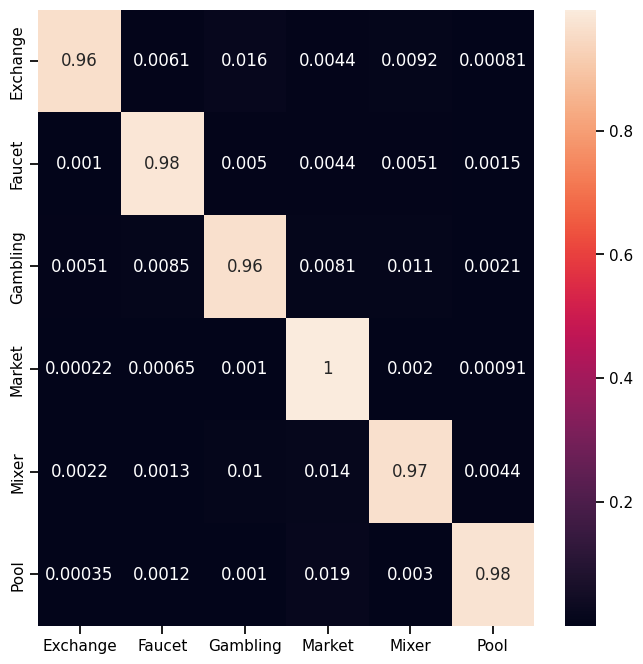

In [9]:
# Average confusion matrix of training set in K-fold

print('Average confusion matrix of training set in {:d}-fold'.format(n_folds))
show_cm_list(train_cm_list, class_names)

In [10]:
def show_rp_list(rp_list):
    # Initialize a dictionary to hold the summed metrics
    summed_metrics = {}
    
    # Iterate over each report in the list
    for report in rp_list:
        for category, metrics in report.items():
            # Check if metrics is a dictionary
            if isinstance(metrics, dict):
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        summed_metrics[category][metric] += value
            else:
                # Handle the case where metrics is a float (like 'accuracy')
                if category not in summed_metrics:
                    summed_metrics[category] = 0
                summed_metrics[category] += metrics

    # Now calculate the average
    avg_metrics = {}
    for category, metrics in summed_metrics.items():
        if isinstance(metrics, dict):
            avg_metrics[category] = {metric: value / len(rp_list) for metric, value in metrics.items()}
        else:
            # Average for float values
            avg_metrics[category] = metrics / len(rp_list)

    # Print the average metrics
    for category, metrics in avg_metrics.items():
        print(f"Category: {category}")
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                print(f"  {metric}: {value}")
        else:
            print(f"  Value: {metrics}")
        print()

# Average classification report of training set in K-fold

print('Average classification report of training set in {:d}-fold'.format(n_folds))
show_rp_list(train_rp_list)

Average classification report of training set in 10-fold
Category: Exchange
  precision: 0.9930990449453428
  recall: 0.9636528063784254
  f1-score: 0.978154306776382

Category: Faucet
  precision: 0.8691401597764143
  recall: 0.9828577898550724
  f1-score: 0.922506938642529

Category: Gambling
  precision: 0.930163070033322
  recall: 0.9648445119605217
  f1-score: 0.9471861911227245

Category: Market
  precision: 0.940075132355987
  recall: 0.99518800288582
  f1-score: 0.966840977074259

Category: Mixer
  precision: 0.9900441685696715
  recall: 0.9677273135779899
  f1-score: 0.9787584171040316

Category: Pool
  precision: 0.9644466988616385
  recall: 0.9750306453907923
  f1-score: 0.969697716567911

Category: accuracy
  Value: 0.9712890933989208

Category: macro avg
  precision: 0.9478280457570627
  recall: 0.97488351167477
  f1-score: 0.9605240912146398

Category: weighted avg
  precision: 0.9723547473449662
  recall: 0.9712890933989208
  f1-score: 0.9714878254786388



Average confusion matrix of validataion set in 10-fold


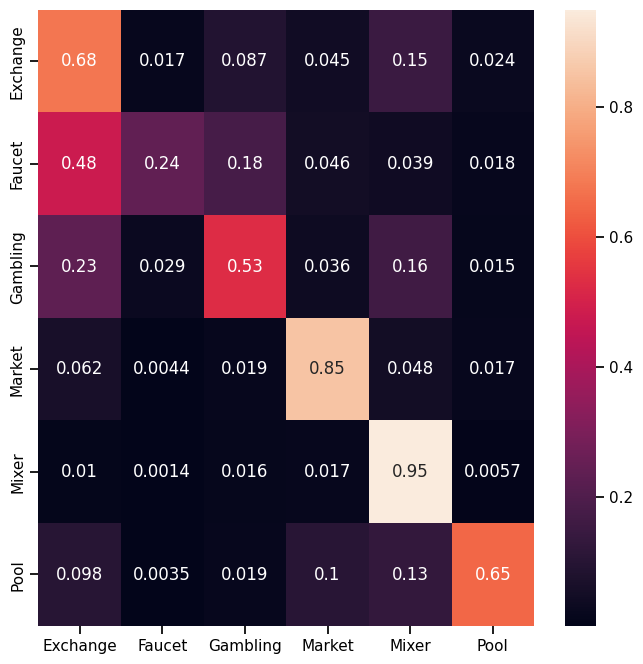

In [11]:
# Average confusion matrix of validataion set in K-fold

print('Average confusion matrix of validataion set in {:d}-fold'.format(n_folds))
show_cm_list(valid_cm_list, class_names)

Average classification report of validataion set in 10-fold
Category: Exchange
  precision: 0.738849819268855
  recall: 0.6767703571954276
  f1-score: 0.7064437171297975

Category: Faucet
  precision: 0.36425455608944046
  recall: 0.24082880434782608
  f1-score: 0.2898816838229033

Category: Gambling
  precision: 0.6310388278225093
  recall: 0.5273194978187129
  f1-score: 0.574515615478852

Category: Market
  precision: 0.8075743620183895
  recall: 0.8495530319739875
  f1-score: 0.8280232707374371

Category: Mixer
  precision: 0.8493941066269161
  recall: 0.9492847819947083
  f1-score: 0.8965638587423171

Category: Pool
  precision: 0.7745733581205148
  recall: 0.6473621556950904
  f1-score: 0.7052277446528683

Category: accuracy
  Value: 0.7874059311408863

Category: macro avg
  precision: 0.6942808383244375
  recall: 0.6485197715042921
  f1-score: 0.6667759817606959

Category: weighted avg
  precision: 0.7771876793354335
  recall: 0.7874059311408863
  f1-score: 0.7795594467124625



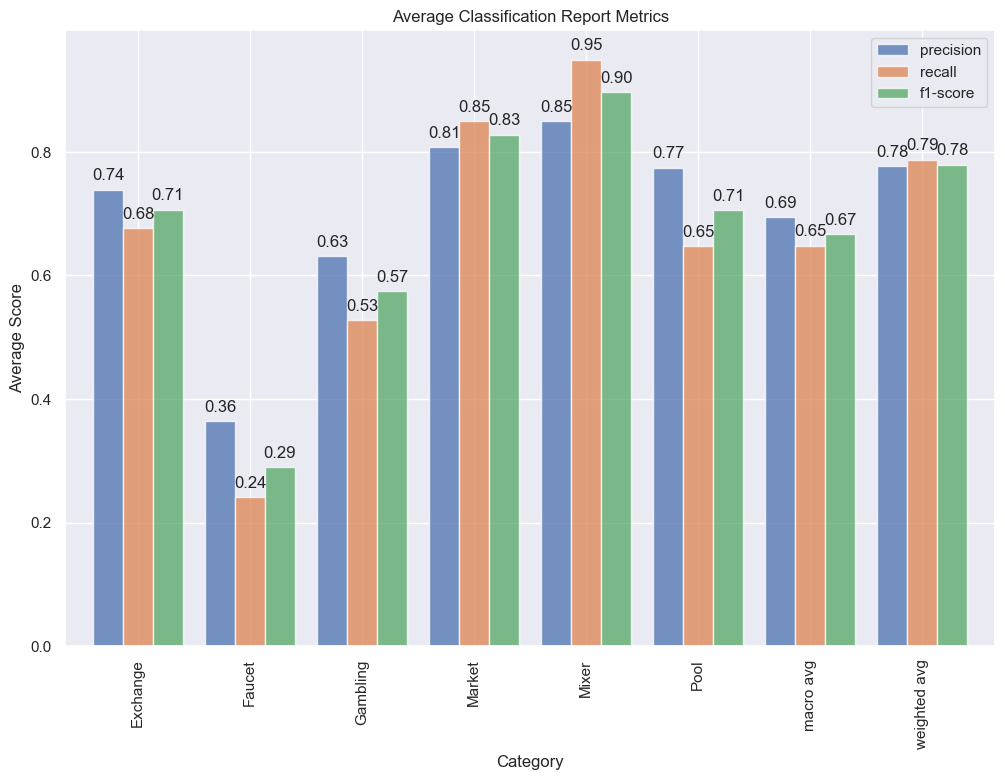

In [25]:
# Average classification report of validataion set in K-fold

print('Average classification report of validataion set in {:d}-fold'.format(n_folds))
show_rp_list(valid_rp_list)

# 初始化用於存儲每個類別平均精確度、召回率和F1分數的字典
averages = {}

# 遍歷每個報告
for report in valid_rp_list:
    # 遍歷報告中的每個類別
    for category, metrics in report.items():
        # 確保 metrics 是字典類型
        if isinstance(metrics, dict):
            # 如果類別第一次出現，則初始化
            if category not in averages:
                averages[category] = {'precision': 0, 'recall': 0, 'f1-score': 0, 'count': 0}
            
            # 累加該類別的指標值
            for metric in ['precision', 'recall', 'f1-score']:
                averages[category][metric] += metrics.get(metric, 0)
            averages[category]['count'] += 1

# 計算平均值
for category, metrics in averages.items():
    for metric in ['precision', 'recall', 'f1-score']:
        metrics[metric] /= metrics['count']

# 刪除計數鍵
for category in averages:
    del averages[category]['count']

# 轉換成DataFrame
df_averages = pd.DataFrame(averages).T

# 繪製柱狀圖並添加數值標籤
ax = df_averages.plot(kind='bar', figsize=(12, 8), width=0.8, alpha=0.75)
ax.set_title('Average Classification Report Metrics')
ax.set_ylabel('Average Score')
ax.set_xlabel('Category')
ax.legend(loc='upper right')

# 在每個柱狀圖上添加數值標籤
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 顯示圖表
plt.show()

'RandomForestClassifier' object has no attribute 'importance_type'
[38 34 35 36 33 32 39 37  0 53 61 57 45 44 56 52 60 41 27 40 31 29 26 43
 42 47 58 62 46 54 63 59 55  1 30  2  8 12 11 10  9  5  7  6 14  4  3 13
 16 15 51 17 18 19 20 48 22 23 24 25 49 28 50 21]


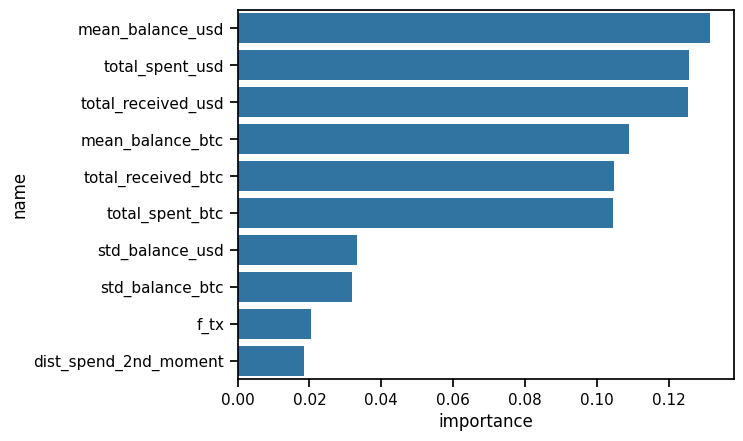

In [13]:
# Feature Importance

if len(fi_list) == 0:
    exit()
    sys.exit()

try:
    print(clf.importance_type)
except Exception as e:
    print(e)

fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_top_10 = df_feature_importances.nlargest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_top_10)  # Modified this line


In [14]:
if run_from_ipython():
    plt.figure(figsize=(16, 32))
    for i in range(10):
        feature_index = df_top_10.index[i]
        feature_name = list(df_top_10['name'])[i]
        feature_data = X[:, feature_index]

        # Check if the lengths match
        if len(y_names) != len(feature_data):
            print(f"Length mismatch for feature '{feature_name}': Length of y_names is {len(y_names)}, length of feature data is {len(feature_data)}")
            continue  # Skip this iteration

        plt.subplot(5, 2, i+1)
        plt.title(feature_name)
        ax = sns.boxplot(x=y_names, y=feature_data)


Length mismatch for feature 'mean_balance_usd': Length of y_names is 6, length of feature data is 694676
Length mismatch for feature 'total_spent_usd': Length of y_names is 6, length of feature data is 694676
Length mismatch for feature 'total_received_usd': Length of y_names is 6, length of feature data is 694676
Length mismatch for feature 'mean_balance_btc': Length of y_names is 6, length of feature data is 694676
Length mismatch for feature 'total_received_btc': Length of y_names is 6, length of feature data is 694676
Length mismatch for feature 'total_spent_btc': Length of y_names is 6, length of feature data is 694676
Length mismatch for feature 'std_balance_usd': Length of y_names is 6, length of feature data is 694676
Length mismatch for feature 'std_balance_btc': Length of y_names is 6, length of feature data is 694676
Length mismatch for feature 'f_tx': Length of y_names is 6, length of feature data is 694676
Length mismatch for feature 'dist_spend_2nd_moment': Length of y_na

<Figure size 1600x3200 with 0 Axes>

[38 34 35 36 33 32 39 37  0 53 61 57 45 44 56 52 60 41 27 40 31 29 26 43
 42 47 58 62 46 54 63 59 55  1 30  2  8 12 11 10  9  5  7  6 14  4  3 13
 16 15 51 17 18 19 20 48 22 23 24 25 49 28 50 21]


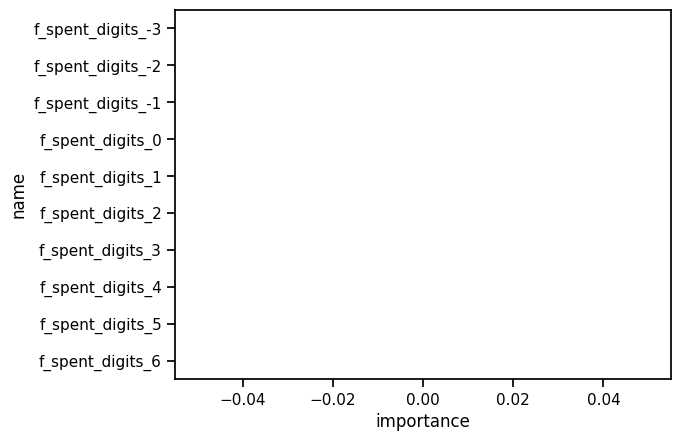

In [15]:
fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_least_10 = df_feature_importances.nsmallest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_least_10)  # Corrected this line


[38 34 35 36 33 32 39 37  0 53 61 57 45 44 56 52 60 41 27 40 31 29 26 43
 42 47 58 62 46 54 63 59 55  1 30  2  8 12 11 10  9  5  7  6 14  4  3 13
 16 15 51 17 18 19 20 48 22 23 24 25 49 28 50 21]


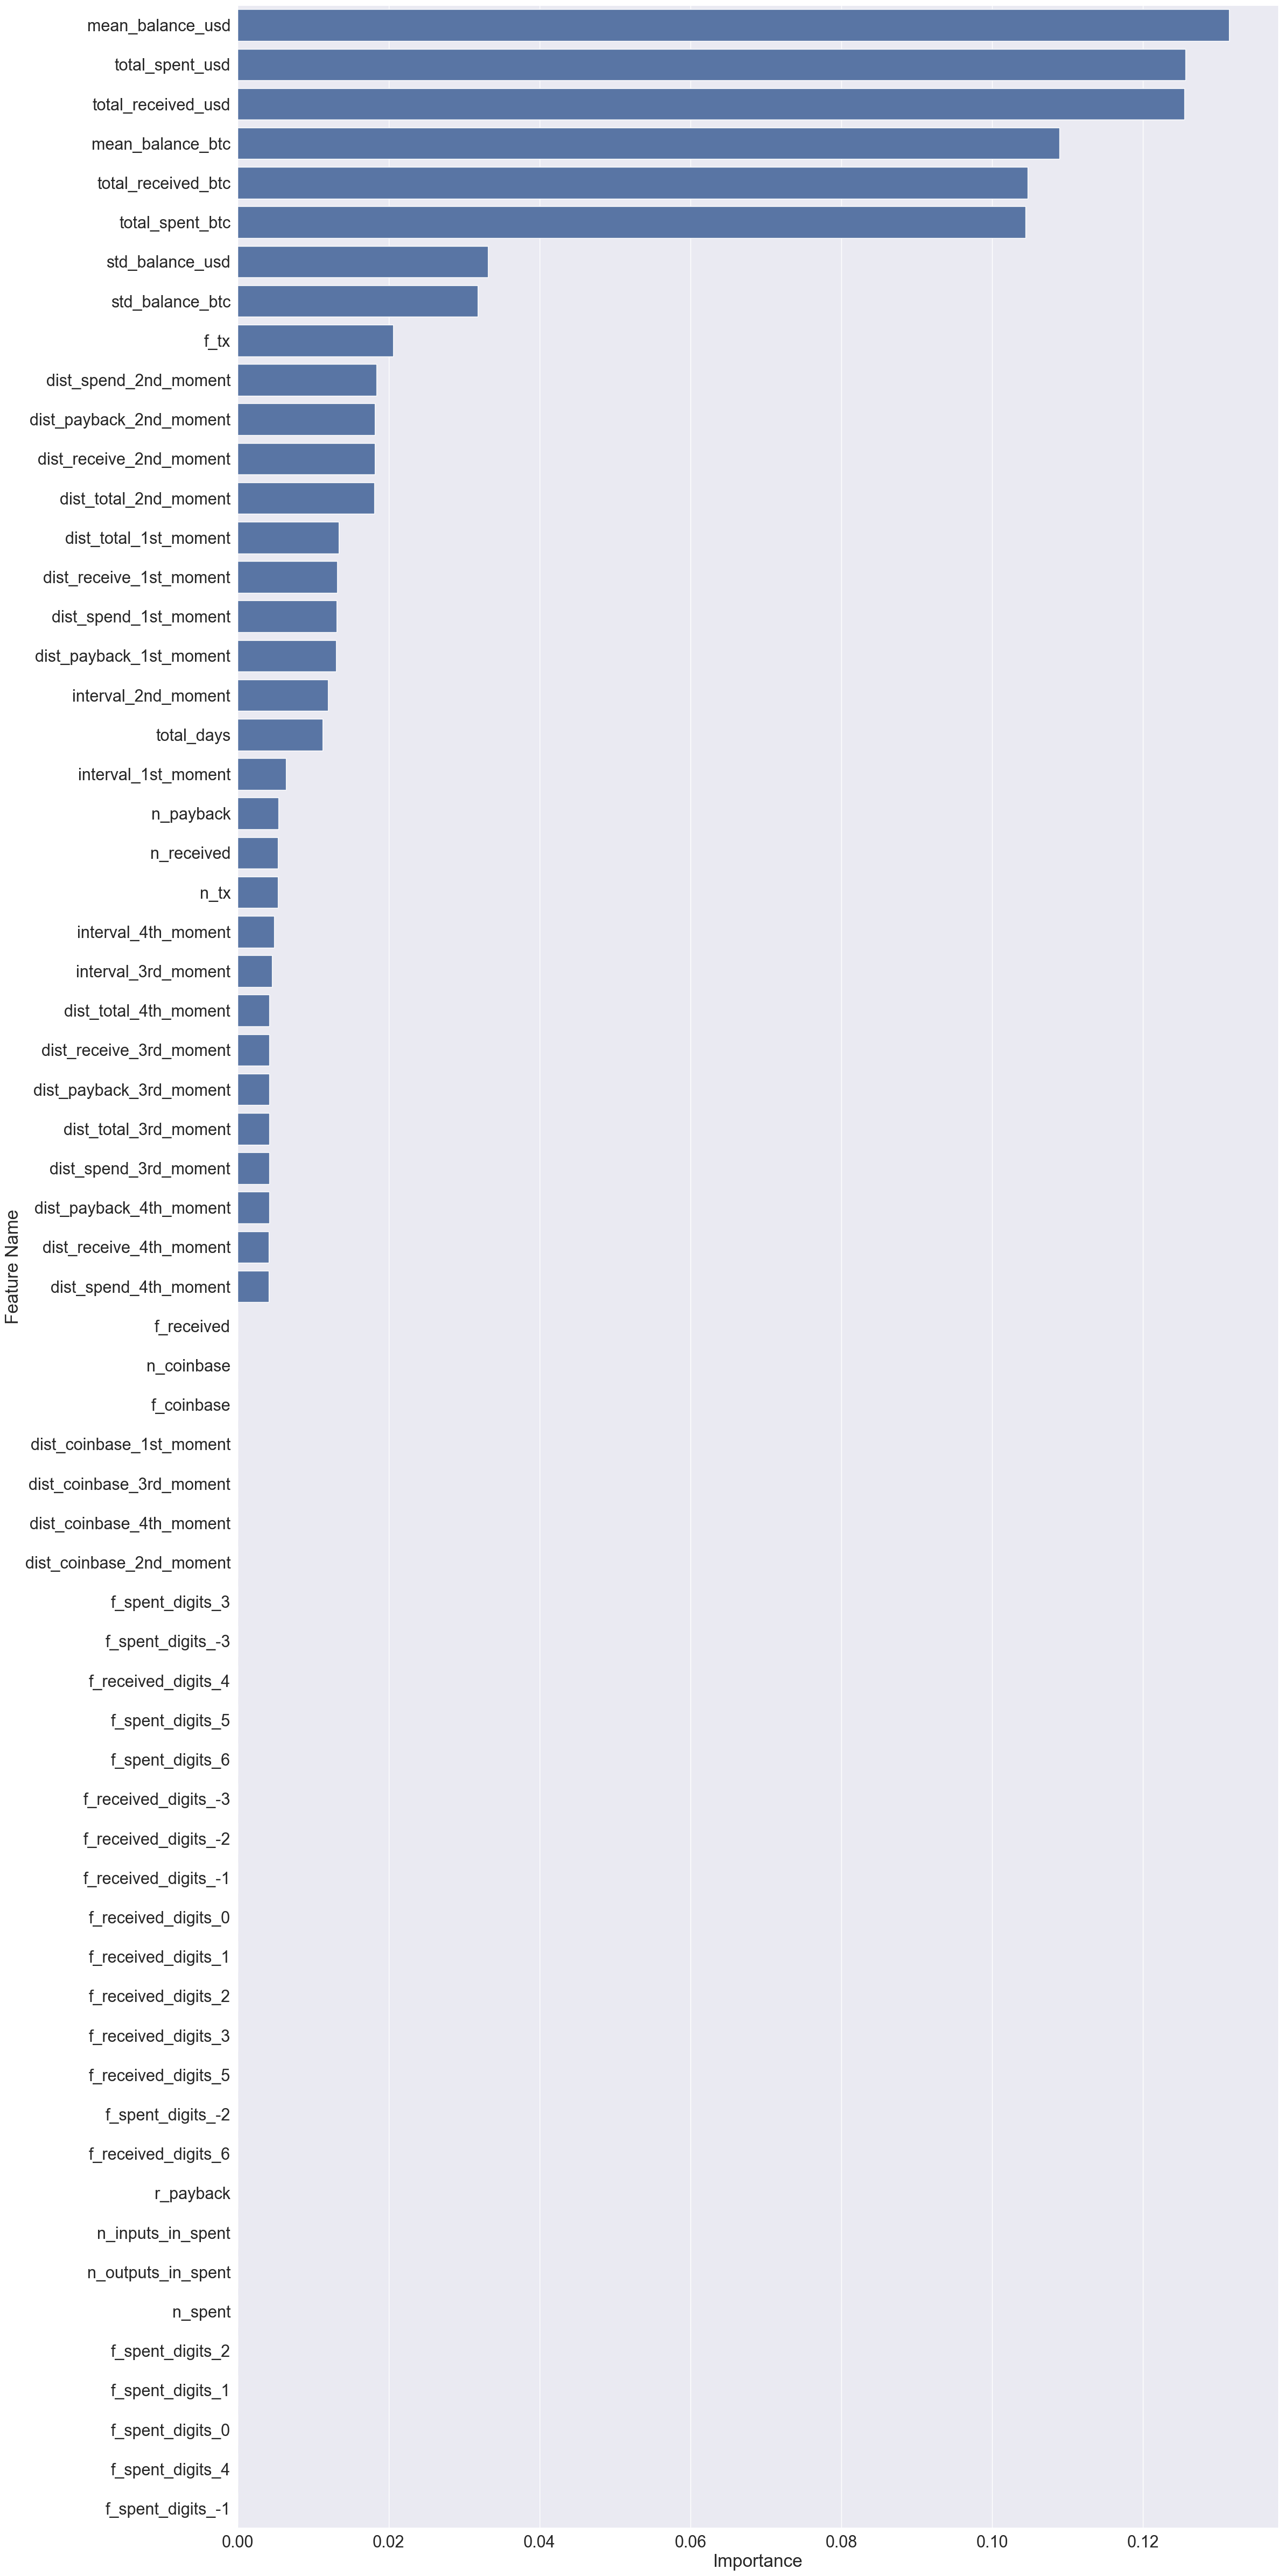

In [16]:
fi_avg = np.mean(fi_list, axis=0)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'Feature Name': features, 'Importance': fi_avg})
    df_least_10 = df_feature_importances.nlargest(len(features), columns='Importance')
    plt.figure(figsize=(24, 48))
    sns.set(font_scale=2)
    sns.barplot(x='Importance', y='Feature Name', data=df_least_10)  # Corrected this line
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('top_10_and_last_10_feature_importance.png')  # Uncomment this line to save the figure


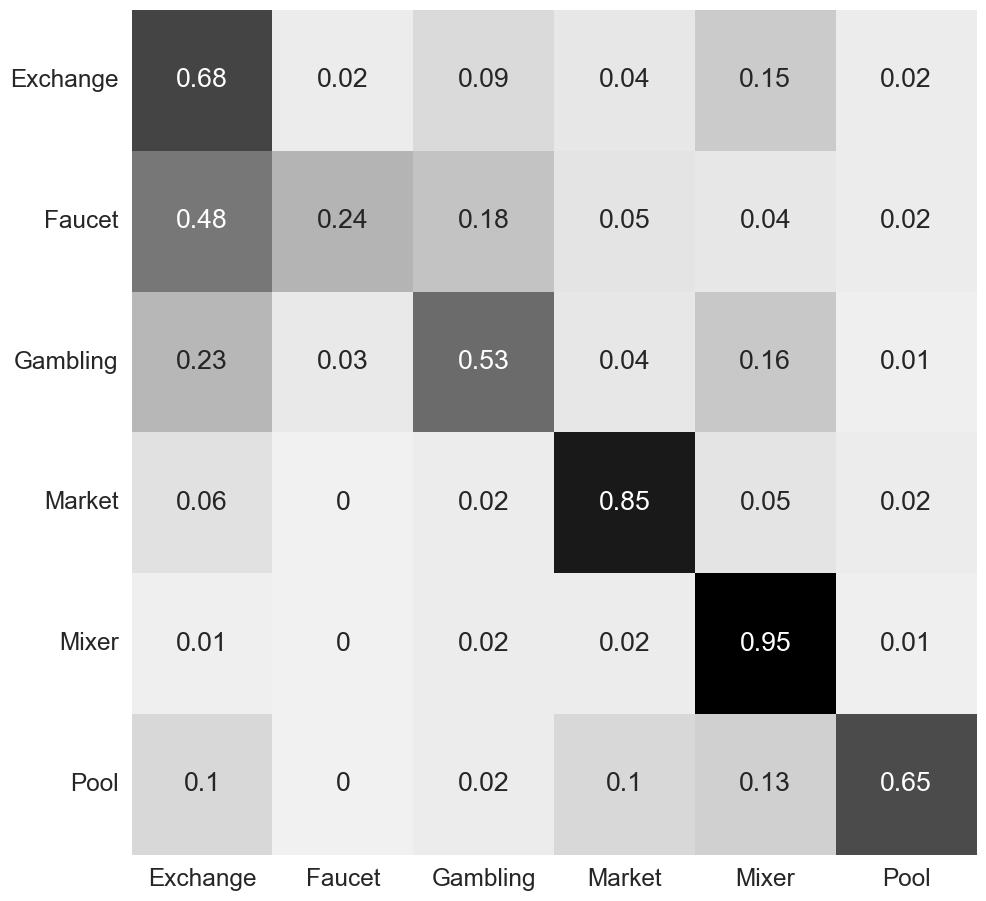

In [17]:
from matplotlib.colors import ListedColormap

cm_avg = np.mean(valid_cm_list, axis=0)
# print(cm_avg)
if run_from_ipython():
    df_cm = pd.DataFrame(cm_avg, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 10))
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = sns.light_palette('black', as_cmap=True)
    # cmap = ListedColormap(['white'])
    sns.set(font_scale=1.6)
    sns.heatmap(df_cm.round(2), annot=True, square=True, cbar=False, cmap=cmap)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('confusion_matrix.png')  # Uncomment this line to save the figure

Average Training Confusion Matrix:
[[9.63652806e-01 6.12229786e-03 1.58537004e-02 4.39248204e-03
  9.17359487e-03 8.05118412e-04]
 [1.04921498e-03 9.82857790e-01 5.04981884e-03 4.40821256e-03
  5.13285024e-03 1.50211353e-03]
 [5.13637209e-03 8.49802790e-03 9.64844512e-01 8.07305544e-03
  1.13372916e-02 2.11074100e-03]
 [2.15413873e-04 6.52769234e-04 1.01070439e-03 9.95188003e-01
  2.01814481e-03 9.14964809e-04]
 [2.20525982e-03 1.34214821e-03 9.97864716e-03 1.43760949e-02
  9.67727314e-01 4.37053630e-03]
 [3.45836068e-04 1.15437641e-03 1.00650210e-03 1.94932216e-02
  2.96941840e-03 9.75030645e-01]]

Average Validation Confusion Matrix:
[[0.67677036 0.01743947 0.08708122 0.04489506 0.14947691 0.02433699]
 [0.47853261 0.2408288  0.17649457 0.04626359 0.03940217 0.01847826]
 [0.2311495  0.02927656 0.5273195  0.03589669 0.16178304 0.01457471]
 [0.06170628 0.00444535 0.01946555 0.84955303 0.04788061 0.01694916]
 [0.01040117 0.00144287 0.01576784 0.01738027 0.94928478 0.00572306]
 [0.0982696

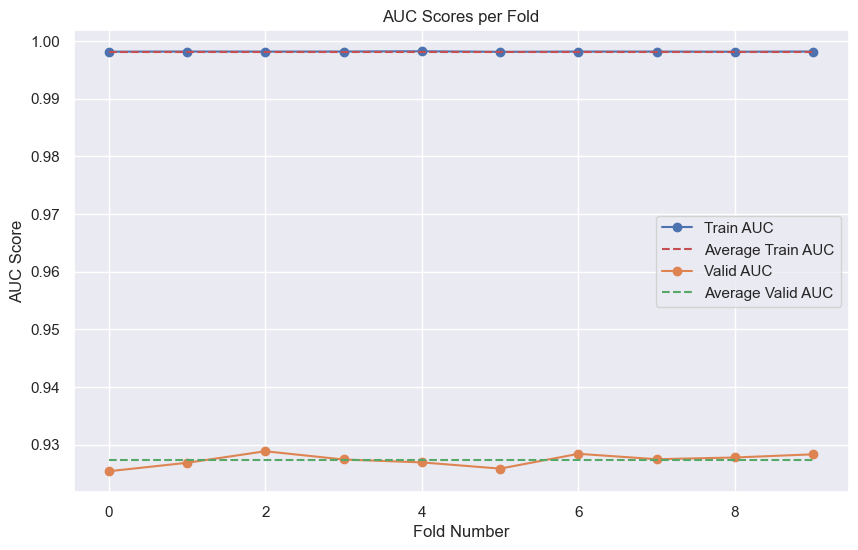

In [18]:
import matplotlib.pyplot as plt

# 计算平均混淆矩阵
avg_train_cm = np.mean(train_cm_list, axis=0)
avg_valid_cm = np.mean(valid_cm_list, axis=0)

# 计算平均AUC分数
avg_train_auc = np.mean(train_auc_list)
avg_valid_auc = np.mean(valid_auc_list)

# 展示平均混淆矩阵
print("Average Training Confusion Matrix:")
print(avg_train_cm)
print("\nAverage Validation Confusion Matrix:")
print(avg_valid_cm)

# 展示平均AUC分数
print(f"\nAverage Train AUC: {avg_train_auc}")
print(f"Average Valid AUC: {avg_valid_auc}")

# 绘制AUC分数图表
plt.figure(figsize=(10, 6))
plt.plot(train_auc_list, label='Train AUC', marker='o')
plt.plot([avg_train_auc] * len(train_auc_list), 'r--', label='Average Train AUC')
plt.plot(valid_auc_list, label='Valid AUC', marker='o')
plt.plot([avg_valid_auc] * len(valid_auc_list), 'g--', label='Average Valid AUC')
plt.title('AUC Scores per Fold')
plt.xlabel('Fold Number')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_18944\1393660083.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


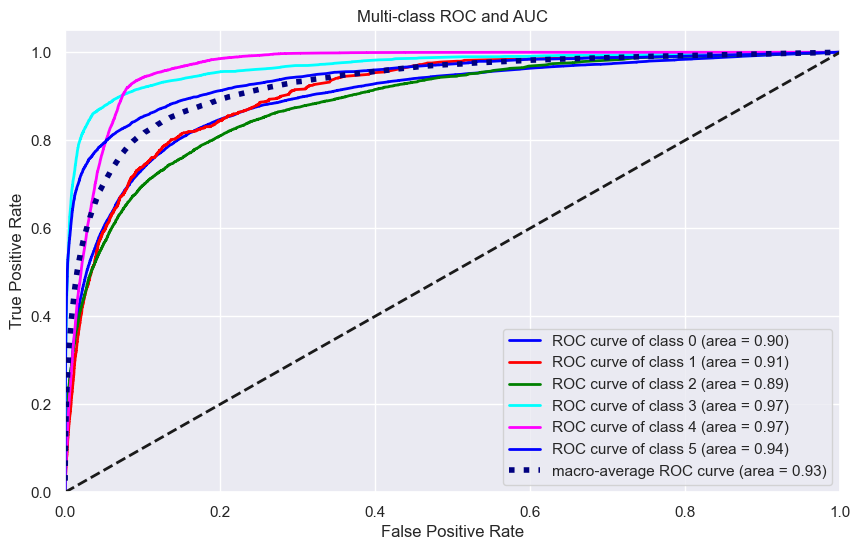

In [19]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# 计算每个类别的FPR和TPR
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)  # 类别的数量

# 计算每个类别的ROC曲线和AUC分数
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid, y_valid_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算宏观平均ROC曲线和AUC分数
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 6))
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# 绘制宏观平均ROC曲线
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# 绘制对角线
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
plt.show()
